# Deep Guitar Amplifier

A little project to practice Tensorflow. I use deep learning to simulate a guitar amplifier following the approach published in [Wright et al., 2020](https://www.mdpi.com/2076-3417/10/3/766/htm)

In [1]:
# Open the ipython console
%qtconsole --JupyterWidget.font_size=11

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.signal import spectrogram, get_window
from importlib import reload
import utils, models
reload(utils)
reload(models)
from utils import *
from models import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as kb
from sklearn.model_selection import train_test_split
from IPython.display import display, Audio

%matplotlib inline

# gpu memory management (attempt to allocate only as much memory as needed)
# check https://www.tensorflow.org/guide/gpu
# this instruction is required, otherwise cudnn returns errors
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# data directories
data_dir = "C:/Users/tore-/Dropbox/Projects/deep guitar amp emulation/datasets/guitar_amplifier_dataset/wav/"
data_proc_dir = 'datasets/guitar_amplifier_dataset/processed/'

# specify the training path (where all training progress is going to be saved)
training_path = 'models/'
if not os.path.exists(training_path): os.makedirs(training_path)
    
# default samplerate for wav data (this variable is ovewritten if dataset is loaded)
samplerate = 44100

# amplifier to be modelled
amp = 'markII'
amp_gain = 'gain6'

# specify the device that tensorflow should use
# '/gpu:0' or '/cpu:0'
tf_device = '/gpu:0'

# specify the pre-emphasis filter used in the loss function during training
preemphasis_weights=[-.85,1]
Preemphasis = tf.constant(preemphasis_weights, 
                          shape=[len(preemphasis_weights),1,1], 
                          dtype=tf.float32)

# Chunk size for training the model
Tx = round(.1*samplerate) 

# Amounts of samples to reject before loss calculation. This parameter is used
# to exclude the model transients from affecting the loss calculation
Trej = round(.025*samplerate)

# Helper function used to pass the training set to model.fit()
# It chunks the dataset and adds an extra dimension (required by tensorflow)
data_fun = lambda X: np.expand_dims(data_chunk(X, Tx, Trej),2)

## 1 - Dataset

### Wave file processing

The next cell loads the wave files and chunks them into shorter time windows. It then shuffles the windows and splits them into a training, validation and test set (proportions: 80%, 10%, 10%). It finally saves the processed datasets to disk. 

Run this cell only if you want to change the dataset splits, otherwise skip and go directly to the next cell.

In [20]:
# Load wave dataset
wavedata = load_wavedata(data_dir)

# Split wave data into chunks of Tchunk length (a few seconds long, so that they 
# can be listened to)
Tchunk = round(5*wavedata['samplerate']) 
X = data_chunk(wavedata['input'], Tchunk)
Y = data_chunk(wavedata[amp][amp_gain], Tchunk)

# shuffle and split into train, validation and test datasets
split_prop = [.8, .1, .1]
Xtrain, Xtest, Ytrain, Ytest = \
    train_test_split(X, Y, test_size=split_prop[2], random_state=1)
Xtrain, Xval, Ytrain, Yval = \
    train_test_split(Xtrain, Ytrain, test_size=split_prop[1]/np.sum(split_prop[:2]), random_state=1)

# save train, validation and test datasets
if not os.path.exists(data_proc_dir):
    os.makedirs(data_proc_dir)
np.savez(data_proc_dir + 'training_data.npz', \
         Xtrain=Xtrain, Ytrain=Ytrain, samplerate=wavedata['samplerate'])
np.savez(data_proc_dir + 'validation_data.npz', \
         Xval=Xval, Yval=Yval, samplerate=wavedata['samplerate'])
np.savez(data_proc_dir + 'test_data.npz', \
         Xtest=Xtest, Ytest=Ytest, samplerate=wavedata['samplerate'])

# free RAM
del wavedata, X, Y, Xtest, Ytest

### Load processed dataset

Load training and validation sets, as processed in the previous cell. 

In [2]:
# Load processed wave data (training and validation sets)
training_data = np.load(data_proc_dir + 'training_data.npz')
validation_data = np.load(data_proc_dir + 'validation_data.npz')
samplerate = training_data['samplerate']
Xtrain = training_data['Xtrain']
Ytrain = training_data['Ytrain']
Xval = validation_data['Xval']
Yval = validation_data['Yval']

### Data exploration

Play and plot an example from the training set (guitar and amplifier sounds).

guitar


markII


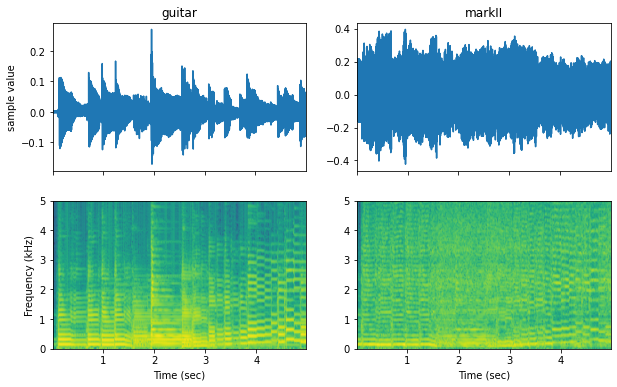

In [4]:
# Example of input/output from the training dataset
idx = 4; 
x = Xtrain[idx,:]
y = Ytrain[idx,:]
t = np.arange(0,len(x))/samplerate

# Play examples
print('guitar')
audio_playback_gui(x)
print(amp)
audio_playback_gui(y)

# Plot wave files
plt.figure(figsize=(10,6))
xlimits = (t[0],t[-1])
ax = plt.subplot(221)
plt.plot(t,x)
ax.set_xticklabels([])
plt.title('guitar')
plt.xlim(xlimits)
plt.ylabel('sample value')
ax = plt.subplot(222)
plt.plot(t,y)
plt.xlim(xlimits)
ax.set_xticklabels([])
plt.title(amp)

# Plot spectrograms 
df = 50; Tn = round_nextpow2(samplerate/df); Tn_overlap = int(.25*Tn)
myspectrogram = lambda x: spectrogram(x, window=get_window('hamming',Tn), fs=samplerate, noverlap=Tn_overlap)
f,t,S = myspectrogram(x)
#f,t,S = spectrogram(x, fs=samplerate)
f /= 1e3; ylimits = (0,5)
ax = plt.subplot(223)
plt.pcolormesh(t, f, 20*np.log10(S), shading='gouraud')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (sec)');
plt.ylim(ylimits)
_,_,S = myspectrogram(y)
ax = plt.subplot(224)
plt.pcolormesh(t, f, 20*np.log10(S), shading='gouraud')
plt.xlabel('Time (sec)');
plt.ylim(ylimits);

## 2 - Amplifier model


The processed audio examples are now a few seconds long in order to enable listening. For training the model it is however more convenient to chunk the examples into much shorter time windows (sub-second). Run the next cell to define how the audio examples should be chunked for training the model.

### Initialize a recurrent amplifier model

Initialize an amplifier model based on a recurrent neural network architecture.
Print model summary.

In [25]:
# specify model name
model_name = 'gru_model'

# model specs
model_specs = """model = recurrent_model(
units=32,
celltype="GRU",
Tx=None,
Trej=Trej,
learning_rate=.001,
name=model_name,
loss=esr_dc(Trej,Preemphasis),
metrics=esr_rej(Trej))"""

# save model specs
with open(training_path + model_name + '_specs.txt','w') as f:
    f.write(model_specs)

# create model
exec(model_specs)
model.summary()

# if a history file with the same model_name already exists, delete it
# so that during training a new file will be generated
history_file = training_path + model_name + '_history.csv'
if os.path.exists(history_file): os.remove(history_file)

Model: "gru_model1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X0 (InputLayer)                 [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
Xrec (GRU)                      (None, None, 32)     3360        X0[0][0]                         
__________________________________________________________________________________________________
Xdense (Dense)                  (None, None, 1)      33          Xrec[0][0]                       
__________________________________________________________________________________________________
Y (Add)                         (None, None, 1)      0           Xdense[0][0]                     
                                                                 X0[0][0]                

### Initialize a convolutional amplifier model


In [14]:
# specify model name
model_name = 'conv_model'

# model specs
model_specs = """model = conv_model(
nlayers=12, 
nchannels=16, 
Tx = None,
Trej=Trej,  
learning_rate=.001,
name=model_name,
loss=esr_dc(Trej,Preemphasis),
metrics=esr_rej(Trej)
)"""

# save model specs
with open(training_path + model_name + '_specs.txt','w') as f:
    f.write(model_specs)

# create model
exec(model_specs)
model.summary()

Model: "conv_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X0 (InputLayer)                 [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
Z0 (Conv1D)                     (None, None, 16)     48          X0[0][0]                         
__________________________________________________________________________________________________
Z0_mix (Conv1D)                 (None, None, 1)      17          Z0[0][0]                         
__________________________________________________________________________________________________
X1 (Add)                        (None, None, 1)      0           X0[0][0]                         
                                                                 Z0_mix[0][0]            

### Load a trained amplifier model

If the current model has already undergone some training, you can **load the previously trained weights** by running the following cell.

In [10]:
model_name = 'gru_model'

# load model
exec(open(training_path + model_name + '_specs.txt','r').read())
model.summary()

# Load trained weights
model.load_weights(training_path + model_name + '_weights.hdf5')

Model: "gru_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X0 (InputLayer)                 [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
Xrec (GRU)                      (None, None, 32)     3360        X0[0][0]                         
__________________________________________________________________________________________________
Xdense (Dense)                  (None, None, 1)      33          Xrec[0][0]                       
__________________________________________________________________________________________________
Y (Add)                         (None, None, 1)      0           Xdense[0][0]                     
                                                                 X0[0][0]                 

### Model training

Train the model for a specified number of epochs by running the following cell.
The model weights that produce the lowest validation loss are saved in `<training_path><model_name>.hdf5`. Training history is also saved in `<training_path><model_name>_history.csv`. Every time this cell is run, the corresponding history log is appended to `<training_path><model_name>_history.csv`.

In [24]:
# define a list of callbacks
callback_list = []

# Specify a callback to save the best model's weights
callback_list.append(keras.callbacks.ModelCheckpoint(
    filepath=training_path + model_name + '_weights.hdf5',
    save_weights_only=True,
    save_best_only=True,
    monitor = 'val_loss'))

# Callback to save training history
callback_list.append(keras.callbacks.CSVLogger(
    training_path + model_name + '_history.csv', 
    append=True))

# Callback to stop training if improvement is too low (<min_delta)
# callback_list.append(keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.01,
#     patience=5))

# Callback to terminate if loss=NaN
callback_list.append(keras.callbacks.TerminateOnNaN())

# train
tic = time.process_time()
with tf.device(tf_device):
    model.fit(x = data_fun(Xtrain), 
              y = data_fun(Ytrain), 
              epochs=1, 
              batch_size=50, 
              validation_data = (data_fun(Xval), \
                                 data_fun(Yval)),
              callbacks = callback_list
             )
toc = time.process_time()
print('Total training time: ' + str((toc - tic)/60) + ' minutes')

940/940 [==============================] - 120s 127ms/step - loss: 191.1290 - ESR: 184.9648 - val_loss: 126.4939 - val_ESR: 121.8467
Total training time: 2.0317708333333333 minutes


### Training history

Show model training history. 

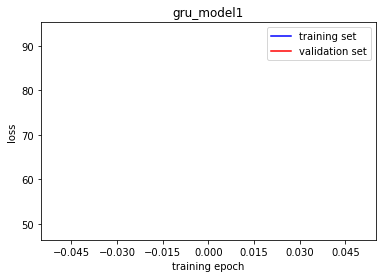

In [19]:
# plot loss curves (training and validation losses)
history = pd.read_csv(training_path + model_name + '_history.csv')
ax = plt.figure().gca()
plt.plot(history['loss'], color='b')
plt.plot(history['val_loss'], color='r')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.legend(['training set','validation set'])
plt.title(model_name)
ax.xaxis.set_major_locator(MaxNLocator(integer=True));

### Model outputs

Plot and play some examples of model outputs from the training and validation sets.

training example 2: original


training example 2: gru_model1


training example 3: original


training example 3: gru_model1


validation example 2: original


validation example 2: gru_model1


validation example 3: original


validation example 3: gru_model1


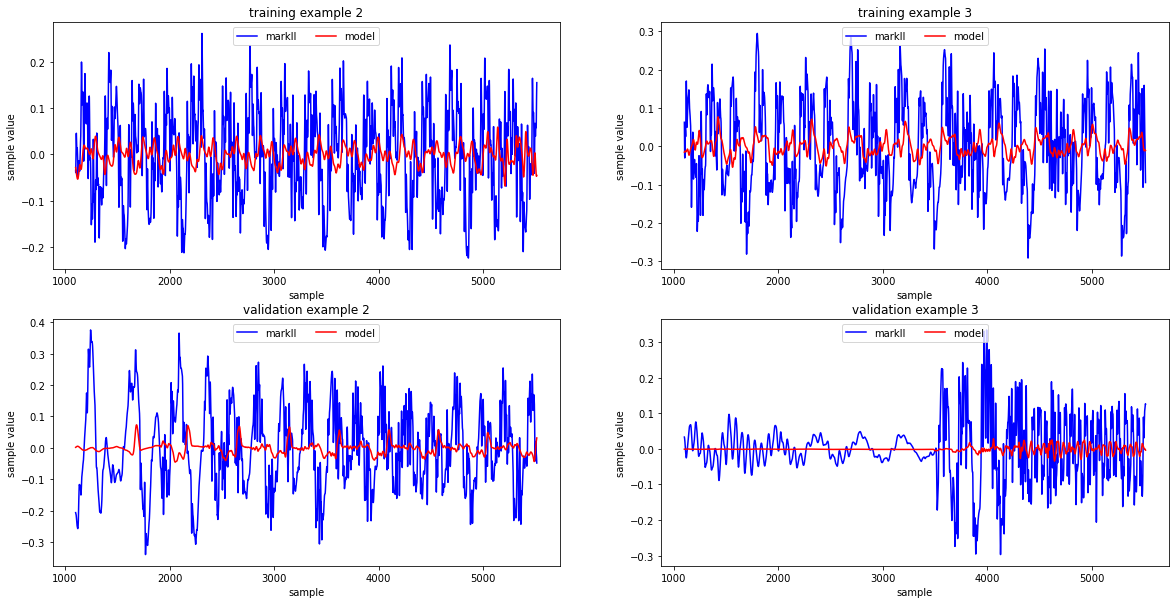

In [20]:
# compute model outputs
idx_vec = [2,3]
X = np.expand_dims(np.concatenate((Xtrain[idx_vec,:],Xval[idx_vec,:])),2)
Y = np.expand_dims(np.concatenate((Ytrain[idx_vec,:],Yval[idx_vec,:])),2)
with tf.device(tf_device):
    Y_hat = model.predict(X)

# plot examples
samples = np.arange(Trej,Trej+Tx)
plt.figure(figsize=[20, 10])
for k in range(2*len(idx_vec)):
    plt.subplot(2, len(idx_vec), k+1)
    plt.plot(samples, Y[k,samples,0], color='b')
    plt.plot(samples, Y_hat[k,samples,0], color='r')
    plt.xlabel('sample')
    plt.ylabel('sample value')
    plt.legend([amp,'model'], loc='upper center', ncol=2)
    plt.title(('validation' if k>=len(idx_vec) else 'training')+' example '+str(idx_vec[k%len(idx_vec)]));
    
# play examples
for k in range(2*len(idx_vec)):
    print(('validation' if k>=len(idx_vec) else 'training')+\
          ' example '+str(idx_vec[k%len(idx_vec)]) + ': original')
    audio_playback_gui(Y[k,Trej:,0])
    print(('validation' if k>=len(idx_vec) else 'training')+\
          ' example '+str(idx_vec[k%len(idx_vec)]) + ': '+model.name)
    audio_playback_gui(Y_hat[k,Trej:,0])
    